# CNN Full Stack

This code were inspired by https://github.com/geniusai-research/Text-Classification which said CNN performing stably. Origin research was by Richard Liao which inspired by  Convolutional Neural Networks for Sentence Classification - Yoo Kim (https://richliao.github.io/supervised/classification/2016/11/26/textclassifier-convolutional/).

Necessary Libary

In [2]:

import numpy as np
import pandas as pd
import pickle
from collections import defaultdict
import re
from bs4 import BeautifulSoup
import sys
import os
os.environ['KERAS_BACKEND']='theano' # Why theano why not
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout
from keras.models import Model
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
plt.switch_backend('agg')
%matplotlib inline

This function were not used in the code as the text already cleaned before.

In [3]:
def clean_str(string):
    string = re.sub(r"\\", "", string)
    string = re.sub(r"\'", "", string)
    string = re.sub(r"\"", "", string)
    return string.strip().lower()

1) Max length set at default 1000
2) Max number of words were set on 20000
3) Output dimension were set on 100
4) validation_split were set on 0.2 but this were ignored which to allow consistency we are using same method spliting with other algorithm and replacing the validation set with test set.



In [4]:
MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

Reading the dataset 

In [5]:
# reading data
df = pd.read_csv('d:/Mini Project/Github/Text Classification/Crime Text Classification/Data/FullTotalCleanedDatasetIndexFinal.csv')
df = df.dropna()
df = df.reset_index(drop=True)
print('Shape of dataset ',df.shape)
print(df.columns)
print('No. of unique classes',len(set(df['jenayah'])))

Shape of dataset  (20349, 2)
Index(['text', 'jenayah'], dtype='object')
No. of unique classes 16


In [8]:
macronum=sorted(set(df['jenayah']))
macro_to_id = dict((note, number) for number, note in enumerate(macronum))

def fun(i):
    return macro_to_id[i]

df['jenayah']=df['jenayah'].apply(fun)


tokenize and save to be use later for single text tested

In [12]:
texts=df['text']
labels=df['jenayah']

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Number of Unique Tokens',len(word_index))

import pickle

# saving
with open('tokenizerultz.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle)

with open('tokenizerultz.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

Number of Unique Tokens 7926


Splitting using stratified shuffle method by adding pad sequences - allowing every text have same length.

In [7]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(labels))
print('Shape of Data Tensor:', data.shape)
print('Shape of Label Tensor:', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

from sklearn.model_selection import StratifiedShuffleSplit    
sss=StratifiedShuffleSplit(n_splits = 5, test_size=0.2, random_state=1)
sss.get_n_splits(data,labels)

for train_index, test_index in sss.split(data,labels):
      #print("TRAIN:", train_index, "TEST:", test_index)
    Train_X, Test_X = data[train_index], data[test_index]
    Train_Y, Test_Y = labels[train_index],labels[test_index]

x_train =  Train_X
y_train =  Train_Y
x_val = Test_X
y_val = Test_Y



# x_train = data[:-nb_validation_samples]
# y_train = labels[:-nb_validation_samples]
# x_val = data[-nb_validation_samples:]
# y_val = labels[-nb_validation_samples:]

Shape of Data Tensor: (20349, 1000)
Shape of Label Tensor: (20349, 16)


word vector were load and obtained from https://github.com/huseinzol05/malaya/tree/master/pretrained-model/wordvector, The word vectors obtained from Wikipedia, Social media, News

In [8]:

embeddings_index = {}
f = open('data3.txt',encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors in Glove 6B 100d.' % len(embeddings_index))

Total 1723550 word vectors in Glove 6B 100d.


If word not existed in the embbeding index, it will given zero. A embedding ayer with input dim , output dim of 100 were set. 

In [9]:
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,trainable=True)

Metrics function were used as the model builded using functional which some functions are not available.

In [10]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Initialize the architecture of base line CNN

In [11]:
import keras
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
l_cov1= Conv1D(128, 5, activation='relu')(embedded_sequences)
l_pool1 = MaxPooling1D(5)(l_cov1)
l_cov2 = Conv1D(128, 5, activation='relu')(l_pool1)
l_pool2 = MaxPooling1D(5)(l_cov2)
l_cov3 = Conv1D(128, 5, activation='relu')(l_pool2)
l_pool3 = MaxPooling1D(35)(l_cov3)  # global max pooling
l_flat = Flatten()(l_pool3)
# l_dense = Dense(128, activation='relu')(l_flat)
l_dense = Dense(128, activation='sigmoid')(l_flat)
preds = Dense(len(macronum), activation='softmax')(l_dense)

model = Model(sequence_input, preds)
# model.compile(loss='categorical_crossentropy',
#               optimizer='rmsprop',
#               metrics=['acc'])
model.compile(optimizer='rmsprop',
              loss='mean_squared_error',
              metrics=['acc',f1_m,precision_m, recall_m])

print("Simplified convolutional neural network")
model.summary()


Simplified convolutional neural network
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1000)]            0         
_________________________________________________________________
embedding (Embedding)        (None, 1000, 100)         792700    
_________________________________________________________________
conv1d (Conv1D)              (None, 996, 128)          64128     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 199, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 195, 128)          82048     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 39, 128)           0         
_________________________________________________________________
conv1d_2 (Conv

Run through baseline parameter, each checkpoint were saved. Only the best one is saved to be used later on. Parameter used  epochs=15, batch_size=2

In [12]:
from keras import metrics

df=ModelCheckpoint('e:/Notebook/MODEL/Baseline_Model/CNNbaseline.hdf5',monitor='val_acc',verbose=1,save_best_only=True)
history=model.fit(x_train, y_train, validation_data=(x_val, y_val),epochs=15, batch_size=2,callbacks=[df])

Epoch 1/15
8137/8140 [============================>.] - ETA: 0s - loss: 0.0307 - acc: 0.6121 - f1_m: 0.5562 - precision_m: 0.6701 - recall_m: 0.4993
Epoch 00001: val_acc improved from -inf to 0.72875, saving model to e:/Notebook/MODEL/Baseline_Model\CNNbaseline.hdf5
8140/8140 [==============================] - 114s 14ms/step - loss: 0.0307 - acc: 0.6121 - f1_m: 0.5563 - precision_m: 0.6701 - recall_m: 0.4993 - val_loss: 0.0224 - val_acc: 0.7287 - val_f1_m: 0.6243 - val_precision_m: 0.7771 - val_recall_m: 0.5479
Epoch 2/15
8140/8140 [==============================] - ETA: 0s - loss: 0.0186 - acc: 0.7805 - f1_m: 0.7667 - precision_m: 0.8550 - recall_m: 0.7225
Epoch 00002: val_acc improved from 0.72875 to 0.77052, saving model to e:/Notebook/MODEL/Baseline_Model\CNNbaseline.hdf5
8140/8140 [==============================] - 114s 14ms/step - loss: 0.0186 - acc: 0.7805 - f1_m: 0.7667 - precision_m: 0.8550 - recall_m: 0.7225 - val_loss: 0.0202 - val_acc: 0.7705 - val_f1_m: 0.7494 - val_precis

In [13]:
y_score = model.predict(x_val)

In [ ]:
y_pred=model.predict_proba(x_val)
matrix = metrics.confusion_matrix(y_val.argmax(axis=1), y_pred.argmax(axis=1))

Evaluation using metrics and figures of the baseline CNN

<ipython-input-14-bd8e83b6824b>:33: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


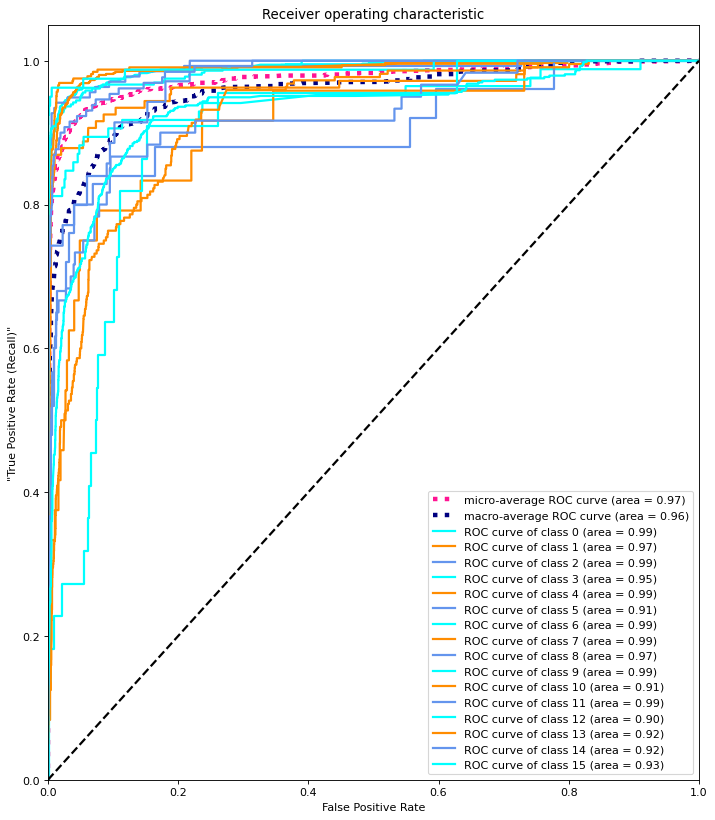

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

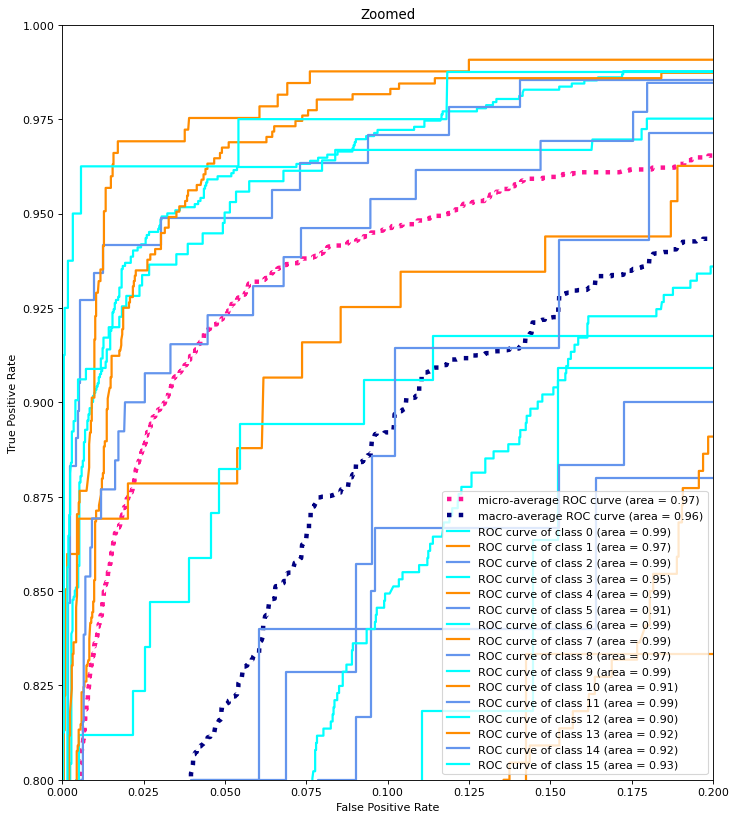

<Figure size 432x288 with 0 Axes>

In [14]:

import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from matplotlib.pyplot import figure

figure(figsize=(10.5, 12.5), dpi=80)
# Plot linewidth.
lw = 2
n_classes = 16
y_test=y_val #= Test_Y
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('"True Positive Rate (Recall)"')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

plt.savefig('e:/Notebook/MODEL/Baseline_Model/roc_cnn_baseline.png')

# Zoom in view of the upper left corner.
plt.figure(2)
figure(figsize=(10.5, 12.5), dpi=80)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Zoomed')
plt.legend(loc="lower right")
plt.show()

plt.savefig('e:/Notebook/MODEL/Baseline_Model/Zoomed_cnn_baseline.png')

In [15]:
loss, accuracy, f1_score, precision, recall = model.evaluate(x_val, y_val, verbose=0)
auc=auc(fpr["micro"], tpr["micro"])
print("Accuracy:",  round(accuracy,4))
print("Recall/Sensitivity:",round(recall,4 ))
print("Auc:", round(auc,4))

Accuracy: 0.8349
Recall/Sensitivity: 0.8134
Auc: 0.9744


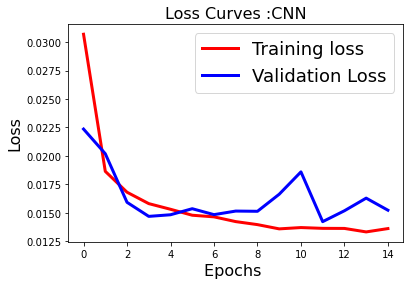

In [16]:
fig1 = plt.figure()
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :CNN',fontsize=16)
fig1.savefig('e:/Notebook/MODEL/Baseline_Model/loss_cnn_baseline.png')
plt.show()

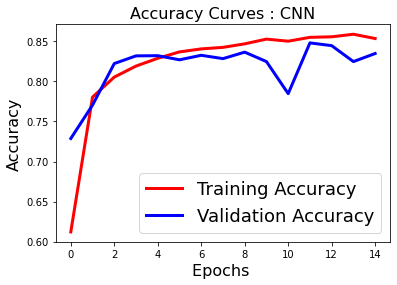

In [17]:
fig2=plt.figure()
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves : CNN',fontsize=16)
fig2.savefig('e:/Notebook/MODEL/Baseline_Model/accuracy_cnn_baselinee.png')
plt.show()

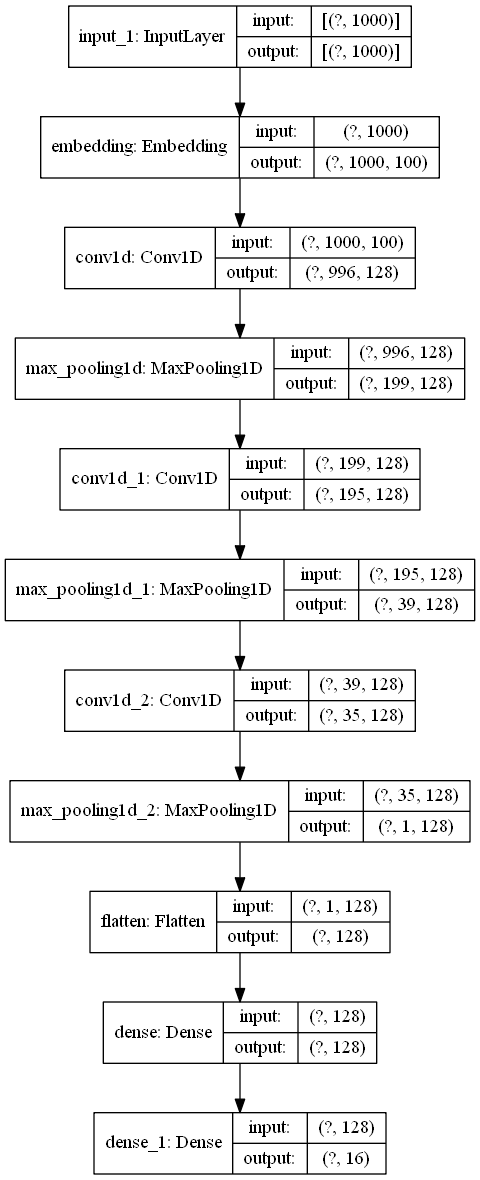

In [18]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='e:/Notebook/MODEL/Baseline_Model/cnn_model_baseline.png', show_shapes=True, show_layer_names=True)

# Hypertuning CNN Model

Hypertuning CNN Model taking so much time as it takes 2 days to complete the parameter search. Set of parameter to be tune are epochs=[10,15,30] , batch_size = [2,4, 8, 16, 32, 64, 128, 256].
First section were on batch_size 2 and second rest of 4, 8, 16, 32, 64, 128, 256. THis to tested whether the line codes of hypertuning were able to used. The each run saved the records on excel reports.

In [10]:
epochs=[10,15,30]
param_grid=dict(batch_size = [2],
nb_epoch = epochs)
# activation=['relu', 'sigmoid'])
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

def create_model():
  sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
  embedded_sequences = embedding_layer(sequence_input)
  l_cov1= Conv1D(128, 5, activation='relu')(embedded_sequences)
  l_pool1 = MaxPooling1D(5)(l_cov1)
  l_cov2 = Conv1D(128, 5, activation='relu')(l_pool1)
  l_pool2 = MaxPooling1D(5)(l_cov2)
  l_cov3 = Conv1D(128, 5, activation='relu')(l_pool2)
  l_pool3 = MaxPooling1D(35)(l_cov3)  # global max pooling
  l_flat = Flatten()(l_pool3)
  # l_dense = Dense(128, activation='relu')(l_flat)
  l_dense = Dense(128, activation='sigmoid')(l_flat)
  preds = Dense(len(macronum), activation='softmax')(l_dense)

  model = Model(sequence_input, preds)
  model.compile(loss='mean_squared_error',
                optimizer='rmsprop',
                metrics=['acc'])

  print("Simplified convolutional neural network")
  model.summary()

  return model


model = KerasClassifier(build_fn=create_model)

grid = GridSearchCV(estimator=model, param_grid=param_grid,n_jobs=1,cv=5,verbose=10)
grid_result = grid.fit(x_train, y_train)



Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5; 1/3] START batch_size=2, nb_epoch=10...................................
Simplified convolutional neural network
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1000)]            0         
_________________________________________________________________
embedding (Embedding)        (None, 1000, 100)         792700    
_________________________________________________________________
conv1d (Conv1D)              (None, 996, 128)          64128     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 199, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 195, 128)          82048     
_________________________________________________________________
max_p

In [20]:
epochs=[10,15,30]
param_grid=dict(batch_size = [4, 8, 16, 32, 64, 128, 256],
nb_epoch = epochs)
# activation=['relu', 'sigmoid'])
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

def create_model():
  sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
  embedded_sequences = embedding_layer(sequence_input)
  l_cov1= Conv1D(128, 5, activation='relu')(embedded_sequences)
  l_pool1 = MaxPooling1D(5)(l_cov1)
  l_cov2 = Conv1D(128, 5, activation='relu')(l_pool1)
  l_pool2 = MaxPooling1D(5)(l_cov2)
  l_cov3 = Conv1D(128, 5, activation='relu')(l_pool2)
  l_pool3 = MaxPooling1D(35)(l_cov3)  # global max pooling
  l_flat = Flatten()(l_pool3)
  # l_dense = Dense(128, activation='relu')(l_flat)
  l_dense = Dense(128, activation='sigmoid')(l_flat)
  preds = Dense(len(macronum), activation='softmax')(l_dense)

  model = Model(sequence_input, preds)
  model.compile(loss='mean_squared_error',
                optimizer='rmsprop',
                metrics=['acc'])

  print("Simplified convolutional neural network")
  model.summary()

  return model


model = KerasClassifier(build_fn=create_model)

grid = GridSearchCV(estimator=model, param_grid=param_grid,n_jobs=1,cv=5,verbose=10)
grid_result = grid.fit(x_train, y_train)



Fitting 5 folds for each of 21 candidates, totalling 105 fits
[CV 1/5; 1/21] START batch_size=4, nb_epoch=10..................................
Simplified convolutional neural network
Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1000)]            0         
_________________________________________________________________
embedding (Embedding)        (None, 1000, 100)         792700    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 996, 128)          64128     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 199, 128)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 195, 128)          82048     
_________________________________________________________________
max

In [ ]:
This result below were overlapped by the first section, the right best parameter were saved on the excel records.

In [11]:
# print best parameter after tuning
print(grid.best_params_)
  
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

{'batch_size': 2, 'nb_epoch': 30}


In [12]:
filename = 'e:/Notebook/MODEL/Hypertune_Model/hypcnnadditional.sav'
pickle.dump(grid.best_estimator_, open(filename, 'wb'))

TypeError: cannot pickle '_thread.RLock' object

In [13]:
best_result = grid.best_score_

print(best_result)

data=pd.DataFrame(grid.cv_results_)
data.to_csv('e:/Notebook/MODEL/Hypertune_Model/CNNEpochBatchNew.csv')

0.838381314277649


This process below are to confirm and reasses the result based on the hypertuned the process and see the evaluation of the model using the metrics and figures. 

In [23]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [24]:
import keras
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
l_cov1= Conv1D(128, 5, activation='relu')(embedded_sequences)
l_pool1 = MaxPooling1D(5)(l_cov1)
l_cov2 = Conv1D(128, 5, activation='relu')(l_pool1)
l_pool2 = MaxPooling1D(5)(l_cov2)
l_cov3 = Conv1D(128, 5, activation='relu')(l_pool2)
l_pool3 = MaxPooling1D(35)(l_cov3)  # global max pooling
l_flat = Flatten()(l_pool3)
# l_dense = Dense(128, activation='relu')(l_flat)
l_dense = Dense(128, activation='sigmoid')(l_flat)
preds = Dense(len(macronum), activation='softmax')(l_dense)

model = Model(sequence_input, preds)
# model.compile(loss='categorical_crossentropy',
#               optimizer='rmsprop',
#               metrics=['acc'])
model.compile(optimizer='rmsprop',
              loss='mean_squared_error',
              metrics=['acc',f1_m,precision_m, recall_m])

print("Simplified convolutional neural network")
model.summary()


Simplified convolutional neural network
Model: "functional_215"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_108 (InputLayer)       [(None, 1000)]            0         
_________________________________________________________________
embedding (Embedding)        (None, 1000, 100)         792700    
_________________________________________________________________
conv1d_321 (Conv1D)          (None, 996, 128)          64128     
_________________________________________________________________
max_pooling1d_321 (MaxPoolin (None, 199, 128)          0         
_________________________________________________________________
conv1d_322 (Conv1D)          (None, 195, 128)          82048     
_________________________________________________________________
max_pooling1d_322 (MaxPoolin (None, 39, 128)           0         
_________________________________________________________________
conv1d_323 (

In [26]:
from keras import metrics

df=ModelCheckpoint('e:/Notebook/MODEL/Hypertune_Model/CNNhypertuned.hdf5',monitor='val_acc',verbose=1,save_best_only=True)
history=model.fit(x_train, y_train, validation_data=(x_val, y_val),epochs=30, batch_size=32,callbacks=[df])

Epoch 1/30
509/509 [==============================] - ETA: 0s - loss: 0.0150 - acc: 0.8262 - f1_m: 0.8314 - precision_m: 0.9097 - recall_m: 0.7738
Epoch 00001: val_acc improved from -inf to 0.85749, saving model to e:/Notebook/MODEL/Hypertune_Model\CNNhypertuned.hdf5
509/509 [==============================] - 51s 99ms/step - loss: 0.0150 - acc: 0.8262 - f1_m: 0.8314 - precision_m: 0.9097 - recall_m: 0.7738 - val_loss: 0.0130 - val_acc: 0.8575 - val_f1_m: 0.8643 - val_precision_m: 0.9023 - val_recall_m: 0.8305
Epoch 2/30
509/509 [==============================] - ETA: 0s - loss: 0.0103 - acc: 0.8853 - f1_m: 0.8902 - precision_m: 0.9248 - recall_m: 0.8591
Epoch 00002: val_acc improved from 0.85749 to 0.87002, saving model to e:/Notebook/MODEL/Hypertune_Model\CNNhypertuned.hdf5
509/509 [==============================] - 51s 100ms/step - loss: 0.0103 - acc: 0.8853 - f1_m: 0.8902 - precision_m: 0.9248 - recall_m: 0.8591 - val_loss: 0.0120 - val_acc: 0.8700 - val_f1_m: 0.8715 - val_precision

In [27]:
y_score = model.predict(x_val)

<ipython-input-28-119e057224d4>:33: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


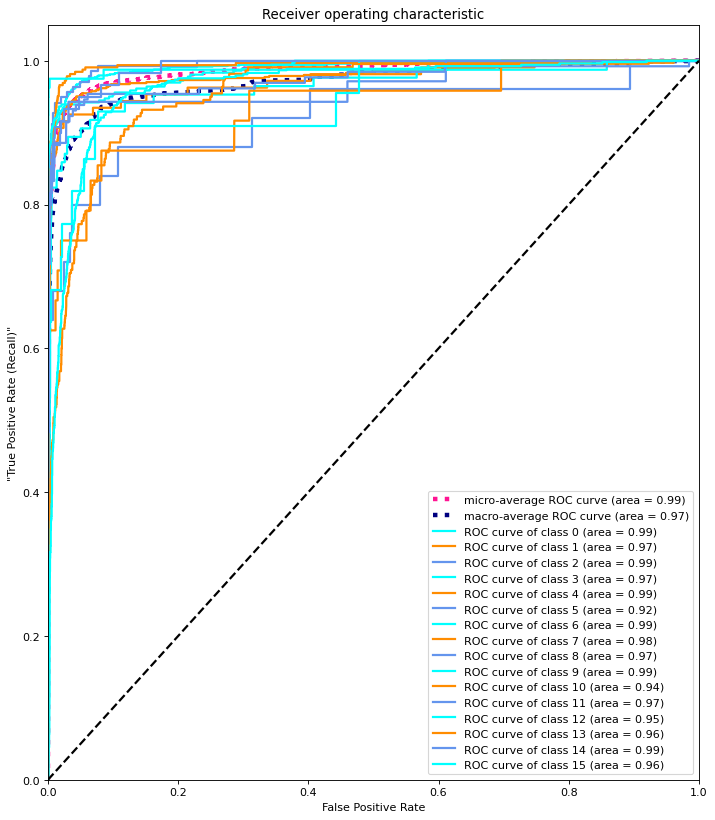

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

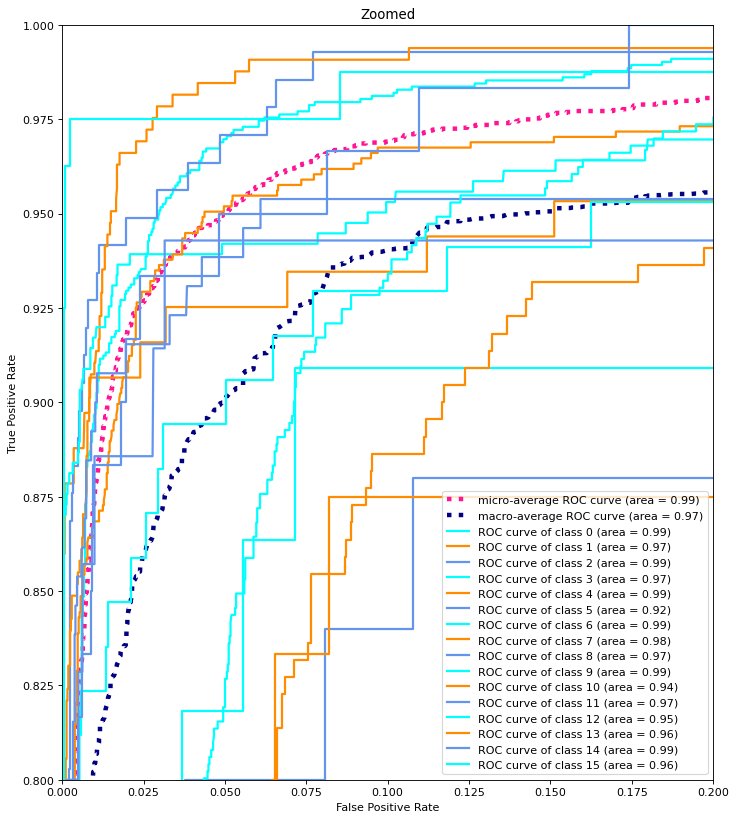

<Figure size 432x288 with 0 Axes>

In [28]:

import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from matplotlib.pyplot import figure

figure(figsize=(10.5, 12.5), dpi=80)
# Plot linewidth.
lw = 2
n_classes = 16
y_test=y_val #= Test_Y
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('"True Positive Rate (Recall)"')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

plt.savefig('e:/Notebook/MODEL/Hypertune_Model/roc_cnn_hypertuned.png')

# Zoom in view of the upper left corner.
plt.figure(2)
figure(figsize=(10.5, 12.5), dpi=80)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Zoomed')
plt.legend(loc="lower right")
plt.show()

plt.savefig('e:/Notebook/MODEL/Hypertune_Model/Zoomed_cnn_hypertuned.png')

In [29]:
loss, accuracy, f1_score, precision, recall = model.evaluate(x_val, y_val, verbose=0)
auc=auc(fpr["micro"], tpr["micro"])
print("Accuracy:",  round(accuracy,4))
print("Recall/Sensitivity:",round(recall,4 ))
print("Auc:", round(auc,4))

Accuracy: 0.8624
Recall/Sensitivity: 0.8534
Auc: 0.9861


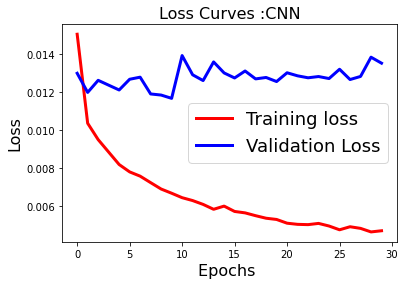

In [30]:
fig1 = plt.figure()
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :CNN',fontsize=16)
fig1.savefig('e:/Notebook/MODEL/Hypertune_Model/loss_cnn_hypertuned.png')
plt.show()

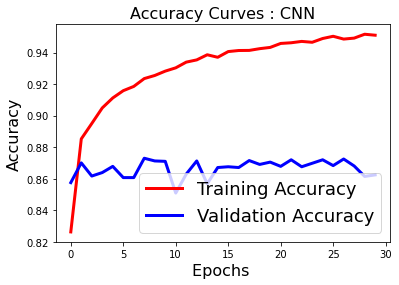

In [31]:
fig2=plt.figure()
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves : CNN',fontsize=16)
fig2.savefig('e:/Notebook/MODEL/Hypertune_Model/accuracy_cnn_hypertuned.png')
plt.show()

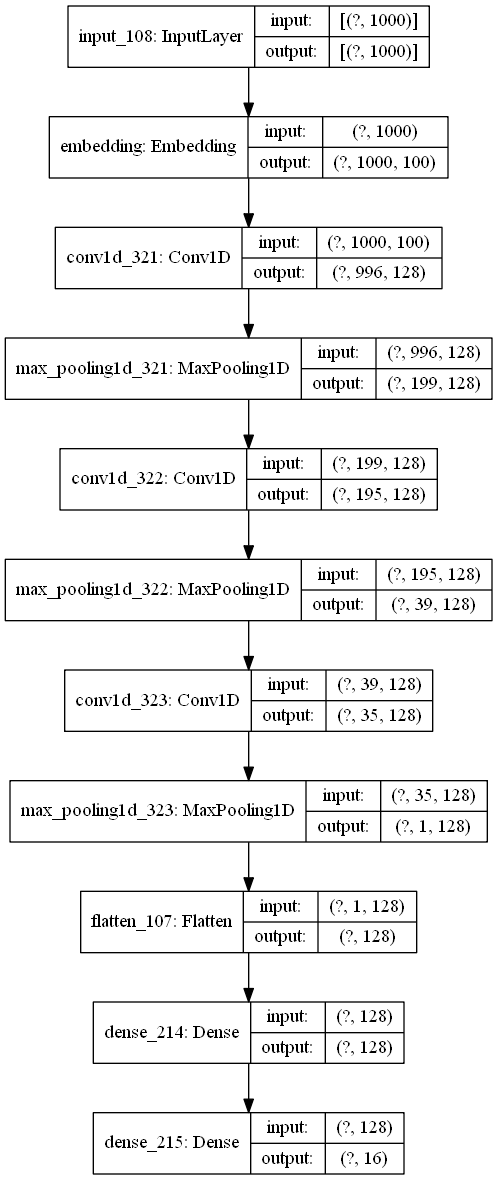

In [32]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='e:/Notebook/MODEL/Hypertune_Model/cnn_model_hypertuned.png', show_shapes=True, show_layer_names=True)

Save the hypertuned model to be tested on the public test.

In [34]:
#run to save model without foreign metrics

import keras
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
l_cov1= Conv1D(128, 5, activation='relu')(embedded_sequences)
l_pool1 = MaxPooling1D(5)(l_cov1)
l_cov2 = Conv1D(128, 5, activation='relu')(l_pool1)
l_pool2 = MaxPooling1D(5)(l_cov2)
l_cov3 = Conv1D(128, 5, activation='relu')(l_pool2)
l_pool3 = MaxPooling1D(35)(l_cov3)  # global max pooling
l_flat = Flatten()(l_pool3)
# l_dense = Dense(128, activation='relu')(l_flat)
l_dense = Dense(128, activation='sigmoid')(l_flat)
preds = Dense(len(macronum), activation='softmax')(l_dense)

model = Model(sequence_input, preds)
# model.compile(loss='categorical_crossentropy',
#               optimizer='rmsprop',
#               metrics=['acc'])
model.compile(optimizer='rmsprop',
              loss='mean_squared_error',
              metrics=['acc'])

print("Simplified convolutional neural network")
model.summary()

from keras import metrics

df=ModelCheckpoint('e:/Notebook/MODEL/Hypertune_Model/CNNhypertunedV2.hdf5',monitor='val_acc',verbose=1,save_best_only=True)
history=model.fit(x_train, y_train, validation_data=(x_val, y_val),epochs=30, batch_size=32,callbacks=[df])

Simplified convolutional neural network
Model: "functional_217"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_109 (InputLayer)       [(None, 1000)]            0         
_________________________________________________________________
embedding (Embedding)        (None, 1000, 100)         792700    
_________________________________________________________________
conv1d_324 (Conv1D)          (None, 996, 128)          64128     
_________________________________________________________________
max_pooling1d_324 (MaxPoolin (None, 199, 128)          0         
_________________________________________________________________
conv1d_325 (Conv1D)          (None, 195, 128)          82048     
_________________________________________________________________
max_pooling1d_325 (MaxPoolin (None, 39, 128)           0         
_________________________________________________________________
conv1d_326 (

Saving the tokenizer to be reuse in the public test

In [35]:
with open('e:/Notebook/MODEL/tokenizerrevisedCNN.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle)

with open('tokenizerultz.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [8]:
!pip install graphviz

In [9]:
from keras.models import load_model
cnn = load_model('e:/Notebook/MODEL/Hypertune_Model/CNNhypertunedV2.hdf5')

# y_pred=cnn.predict_proba(x_val)
# matrix = metrics.confusion_matrix(y_val.argmax(axis=1), y_pred.argmax(axis=1))

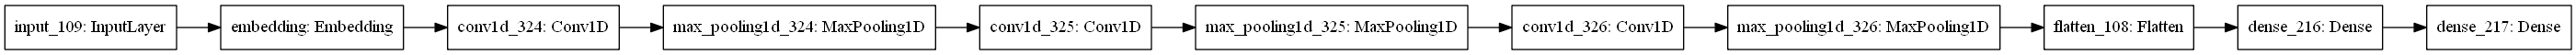

In [12]:
from tensorflow.keras.utils import plot_model
plot_model(cnn, to_file='model.png', rankdir='LR')
